# CEFR Level Classification using FLAN-T5 + LoRA

1. Feature Injection (The "Cheat Sheet" Method) [Recommended]
Since the model struggles to judge "complexity," we can calculate standard readability metrics (math formulas) and paste them into the prompt.

How: Calculate Flesch-Kincaid Grade, Avg Sentence Length, and Type-Token Ratio (vocabulary richness) for each text.
New Prompt:
"Stats: Flesch-Score: 65, Avg-Len: 12 words. Text: [Content]. Question: What is the CEFR level?"

Why it works: It gives the small model hard numbers to correlate. If Avg-Len > 20, it learns to predict C1/C2 instantly, bypassing the need for deep linguistic understanding.


In the current setup, the `flan-t5-small` model is trying to perform "Deep Reading." It looks at words and syntax to guess if a text is B2 or C1. Because the model is small (80M parameters), it often misses the subtle differences in grammar or tone that separate those levels.

Here is exactly what Feature Injection does to solve that:

### 1. It Provides "Numerical Anchors"

Currently, the model only sees a wall of text. With Feature Injection, you are adding a **header** that acts as a "Cheat Sheet."

* **Flesch-Kincaid Grade:** This tells the model the "mathematical" difficulty.
* **Average Sentence Length:** This is a high-correlation feature. In English, A1 texts usually have 5–8 words per sentence, while C2 academic texts often have 25+.
* **Type-Token Ratio (TTR):** This measures vocabulary richness. A low score means the same words are repeated (Basic); a high score means a diverse, advanced vocabulary.

### 2. It Shifts the Task from "Reading" to "Correlation"

Without features, the model must:

1. Parse the syntax.
2. Understand the complexity.
3. Map it to CEFR.

**With features, the model can "cheat":**
It learns a mathematical rule: `IF Avg-Len > 22 AND Flesch-Score > 80 THEN predict C1`. This is much easier for a small model to learn via LoRA than trying to understand the nuances of the subjunctive mood or complex passive structures.

### 3. It Bypasses the "B2 Gravity Well"

In your previous results, the model had **91% recall for B2** but **0% for B1 and C1**. This happened because B1, B2, and C1 all "look" similar to a small model.

By injecting features, you give the model a reason to distinguish them. A B1 text might have an `Avg-Len` of 12, while a C1 text has 22. Even if the *content* looks similar to the model, the *stats* are different. The model will start using these numbers to "break the tie" and stop defaulting everything to B2.

### Exactly how it appears to the model:

Instead of just seeing:

> "The implementation of hierarchical structures in neural networks..."

The model sees:

> **Stats: Flesch: 14.2, Avg-Len: 28.5, TTR: 0.85.**
> Text: "The implementation of hierarchical structures in neural networks..."

The model now has **pre-computed evidence** to support a C2 prediction before it even reads the first word of your text.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# Ensure src is in path
if 'src' not in sys.path:
    sys.path.append(os.path.abspath('src'))

from src.data_loader import download_cefr_dataset, load_cefr_data
from src.prompt_manager import PromptManagerFeatureInjectionWithSpacy

W0116 17:15:59.413000 12376 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


### 1. Load Data

In [2]:
# Download and load the dataset
data_path = download_cefr_dataset()
df = load_cefr_data(data_path)

# Display basic info
print(f"Total unique records: {len(df)}")
df.head()

Dataset downloaded to: C:\Users\almud\.cache\kagglehub\datasets\amontgomerie\cefr-levelled-english-texts\versions\1
Found 1 CSV file(s): ['C:\\Users\\almud\\.cache\\kagglehub\\datasets\\amontgomerie\\cefr-levelled-english-texts\\versions\\1\\cefr_leveled_texts.csv']
Loaded 1494 rows.
Total unique records: 1494


,text,label
0,Hi!\nI've been meaning to write for ages and f...,B2
1,﻿It was not so much how hard people found the ...,B2
2,Keith recently came back from a trip to Chicag...,B2
3,"The Griffith Observatory is a planetarium, and...",B2
4,-LRB- The Hollywood Reporter -RRB- It's offici...,B2


### 2. Exploratory Data Analysis (EDA)

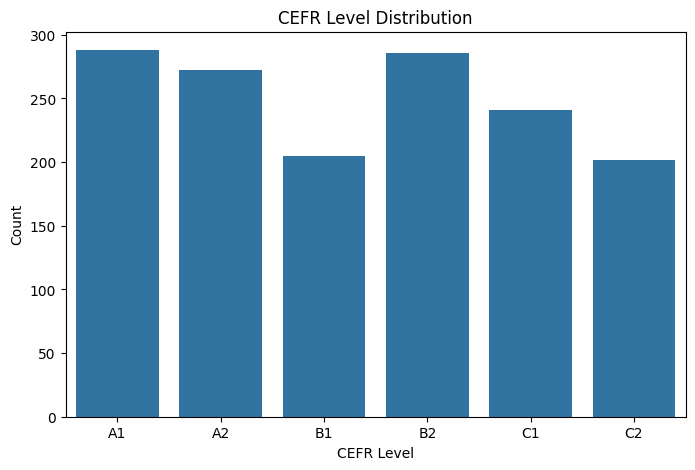

label
A1    288
B2    286
A2    272
C1    241
B1    205
C2    202
Name: count, dtype: int64


In [3]:
# Check class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, order=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])
plt.title('CEFR Level Distribution')
plt.xlabel('CEFR Level')
plt.ylabel('Count')
plt.show()

print(df['label'].value_counts())

### 3. Preprocessing and Splitting

In [4]:
# 1. Initialize the Combined Manager
# Ensure you have updated src/prompt_manager.py with the code I gave you in the previous turn
from src.prompt_manager import PromptManagerOrdinalFeatureInjection, OrdinalSeq2SeqTrainer
prompt_mgr = PromptManagerOrdinalFeatureInjection()

# 2. Define Mapping for Ordinal Loss
# We need integers to calculate "Distance" (e.g. |0 - 5| = 5)
label_to_id = {"A1": 0, "A2": 1, "B1": 2, "B2": 3, "C1": 4, "C2": 5}

def format_dataset(dataframe):
    df_f = dataframe.copy()
    
    # Feature Injection: Adds [Stats -> GL:12 | DEP:4.5...] to the input
    df_f['input_text'] = df_f['text'].apply(lambda x: prompt_mgr.generate_prompt(x))
    
    # Target: Standard CEFR Label
    df_f['target_text'] = df_f['label']
    
    # Ordinal Label: Integer for the custom loss function
    df_f['ordinal_label'] = df_f['label'].map(label_to_id)
    
    return df_f

# 3. Stratified Split (Standard 6-Class Stratification)
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

# 4. Apply Formatting
train_df = format_dataset(train_df)
val_df = format_dataset(val_df)
test_df = format_dataset(test_df)

# 5. Create DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df),
    'test': Dataset.from_pandas(test_df)
})

print(f"Dataset Ready. Sample Input:\n{dataset['train'][0]['input_text'][:150]}...")

Dataset Ready. Sample Input:
[Stats -> GL:10.589370540669101 | SL:22.9 | DEP:6.79 | PSV:11 | DEN:0.34]
Task: Classify the CEFR proficiency level of this text (A1, A2, B1, B2, C1, ...


### 4. Tokenization

In [5]:
from transformers import AutoTokenizer

# 1. Configuration
model_id = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_id)

def preprocess_function(examples):
    """
    Tokenizes the feature-injected prompts and CEFR labels for training.
    """
    # 1. Extract and clean whitespace from the injected prompts and target labels
    # 'input_text' now contains [Stats -> GL:X | DEP:Y | PSV:Z | DEN:W]
    inputs = [str(i).strip() for i in examples["input_text"]]
    targets = [str(t).strip() for t in examples["target_text"]]
    
    # 2. Tokenize inputs with standard T5 sequence length
    model_inputs = tokenizer(
        inputs, 
        max_length=512, 
        truncation=True,
        padding=False # Padding is handled dynamically by DataCollatorForSeq2Seq
    )
    
    # 3. Tokenize targets using modern text_target syntax
    # T5 requires specific handling for the decoder-side vocabulary
    labels = tokenizer(
        text_target=targets, 
        max_length=8, # Optimized for short CEFR labels like "B2" or "C1"
        truncation=True,
        padding=False
    )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# 4. Apply mapping and remove all original raw text columns
# This ensures only tensors are passed to the trainer
tokenized_datasets = dataset.map(
    preprocess_function, 
    batched=True, 
    remove_columns=dataset.column_names['train'],
    desc="Tokenizing dataset with Advanced Feature Injection"
)

# 5. Verification
print("Tokenization Complete.")
print(tokenized_datasets)

# Verification: Check if the stats header is present in the token IDs
sample_input = tokenized_datasets["train"][0]["input_ids"]
decoded_sample = tokenizer.decode(sample_input[:30])
print(f"\nDecoded Prompt Start: {decoded_sample}...")

Tokenizing dataset with Advanced Feature Injection:   0%|          | 0/1045 [00:00<?, ? examples/s]

Tokenizing dataset with Advanced Feature Injection:   0%|          | 0/224 [00:00<?, ? examples/s]

Tokenizing dataset with Advanced Feature Injection:   0%|          | 0/225 [00:00<?, ? examples/s]

Tokenization Complete.
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1045
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 224
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 225
    })
})

Decoded Prompt Start: [Stats -> GL:10.589370540669101 | SL:22.9 | DEP:6.79...


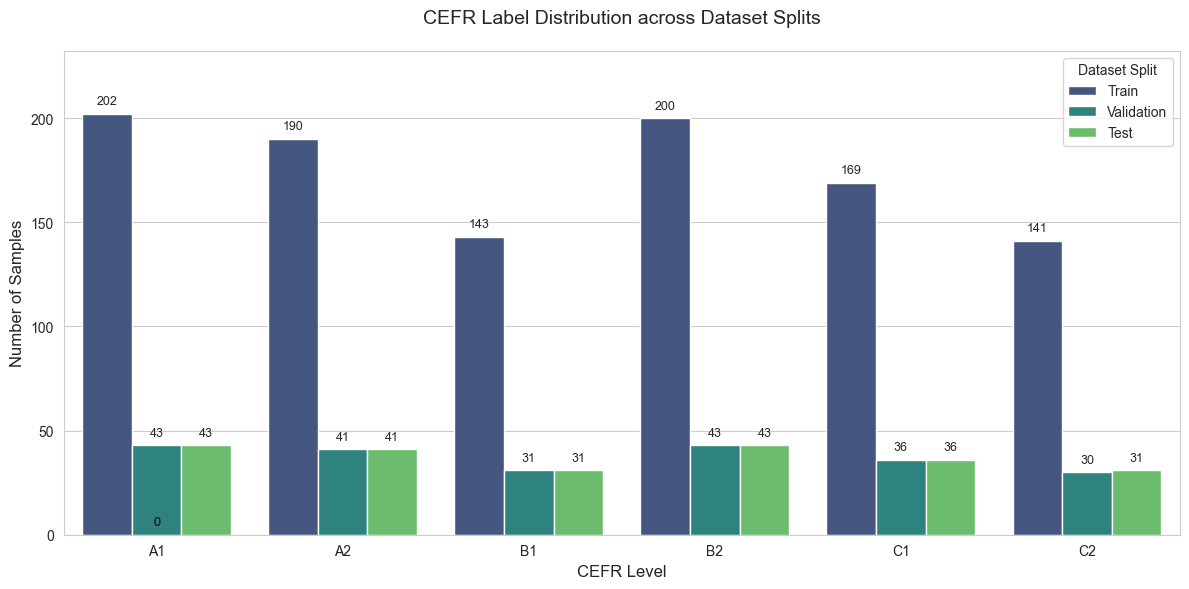

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_split_distributions(train_df, val_df, test_df):
    # 1. Prepare the data for plotting
    order = ["A1", "A2", "B1", "B2", "C1", "C2"]
    
    # Create count dataframes for each split
    t_counts = train_df['label'].value_counts().reindex(order).reset_index()
    t_counts['Split'] = 'Train'
    
    v_counts = val_df['label'].value_counts().reindex(order).reset_index()
    v_counts['Split'] = 'Validation'
    
    s_counts = test_df['label'].value_counts().reindex(order).reset_index()
    s_counts['Split'] = 'Test'
    
    # Combine into a single long-form dataframe
    plot_df = pd.concat([t_counts, v_counts, s_counts])
    plot_df.columns = ['CEFR Level', 'Count', 'Split']
    
    # 2. Create the plot
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    ax = sns.barplot(data=plot_df, x='CEFR Level', y='Count', hue='Split', palette='viridis')
    
    # Add labels on top of bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=9)

    plt.title('CEFR Label Distribution across Dataset Splits', fontsize=14, pad=20)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.xlabel('CEFR Level', fontsize=12)
    plt.legend(title='Dataset Split')
    plt.ylim(0, plot_df['Count'].max() * 1.15) # Add space for labels
    
    plt.tight_layout()
    plt.show()

# Execute the plot
plot_split_distributions(train_df, val_df, test_df)

## Phase 2: Zero-Shot Baseline Evaluation
We will now evaluate the pretrained FLAN-T5 model on the test set to establish a baseline.

**CLEANING GPU CACHE**

In [7]:
import gc
import torch

# Clear existing model if it exists
if 'model' in locals():
    del model
    
gc.collect()
torch.cuda.empty_cache()

# Now try running your original loading code...

In [13]:
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig
import torch

# 1. Hardware check
device = "cuda" if torch.cuda.is_available() else "cpu"

# 2. Updated BitsAndBytes Configuration
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=True 
)

# 3. Load Model with Stability Fixes
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_id,
    quantization_config=bnb_config if device == "cuda" else None,
    device_map="auto" if device == "cuda" else None,
    
    # CRITICAL CHANGE FOR ORDINAL LOSS:
    # Use float32 to prevent numerical instability during custom loss calculation
    torch_dtype=torch.float32 
)

# Ensure CPU fallback
if device == "cpu":
    model = model.to("cpu")

print(f"Model loaded successfully on {device}. Ready for Ordinal Training pipeline.")

Model loaded successfully on cuda. Ready for Ordinal Training pipeline.


In [15]:
from tqdm.auto import tqdm 
import torch
import string
import re  # Added for robust cleaning
import importlib
import numpy as np
from sklearn.metrics import accuracy_score
import src.prompt_manager

def evaluate_ordinal_zero_shot(model, tokenizer, dataset, batch_size=8):
    model.eval()
    
    # 1. Reload Manager
    importlib.reload(src.prompt_manager)
    from src.prompt_manager import PromptManagerOrdinalFeatureInjection 
    prompt_mgr = PromptManagerOrdinalFeatureInjection()
    
    test_data = dataset['test']
    references = test_data['target_text']
    predictions = []
    inputs_text = []
    
    device = next(model.parameters()).device
    print(f"Running Ordinal Feature-Injected inference on {device}...")
    
    for i in tqdm(range(0, len(test_data), batch_size)):
        batch_raw_texts = test_data[i:i+batch_size]['text']
        
        # Generate Prompts
        batch_texts = [prompt_mgr.generate_prompt(t) for t in batch_raw_texts]
        inputs_text.extend(batch_raw_texts)
        
        inputs = tokenizer(
            batch_texts, 
            return_tensors="pt", 
            padding=True, 
            truncation=True, 
            max_length=512
        ).to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs, 
                max_new_tokens=5, 
                num_beams=1, 
                do_sample=False
            ) 
        
        batch_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        predictions.extend(batch_preds)
        
    return predictions, references, inputs_text

# --- ROBUST CLEANING FUNCTION ---
def clean_prediction(pred):
    """
    Extracts the first valid CEFR label (e.g., A1, C2) found in the string.
    Removes punctuation and extra text like 'Level B1.'
    """
    pred = str(pred).upper()
    
    # Regex to find exactly A1, A2, B1, B2, C1, C2
    match = re.search(r'\b([A-C][1-2])\b', pred)
    
    if match:
        return match.group(1) # Return the found label (e.g., "B2")
    return "UNKNOWN" # Return explicit unknown if no label found

# --- EXECUTION ---

# 1. Run Evaluation
preds, refs, texts = evaluate_ordinal_zero_shot(model, tokenizer, dataset)

# 2. Apply Robust Cleaning
preds_clean = [clean_prediction(p) for p in preds]

# 3. Calculate Metrics (Accuracy & MAE)
label_map = {"A1": 0, "A2": 1, "B1": 2, "B2": 3, "C1": 4, "C2": 5}
y_true = []
y_pred = []

# Only calculate MAE for valid predictions
for p, r in zip(preds_clean, refs):
    if p in label_map and r in label_map:
        y_pred.append(label_map[p])
        y_true.append(label_map[r])

# Handle edge case where model predicts all UNKNOWN
if len(y_true) > 0:
    mae = np.mean(np.abs(np.array(y_true) - np.array(y_pred)))
    acc = accuracy_score(y_true, y_pred)
else:
    mae = 0.0
    acc = 0.0

print(f"\nResults:")
print(f"Accuracy: {acc:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print("-" * 30)

# 4. Display Samples
print("Sample Predictions:")
for i in range(5):
    clean_text = texts[i].replace('\n', ' ')[:100] + "..."
    print(f"Text: {clean_text}")
    print(f"Ground Truth: {refs[i]} | Raw Pred: {preds[i]} | Clean Pred: {preds_clean[i]}")
    print("-" * 30)

Running Ordinal Feature-Injected inference on cuda:0...


  0%|          | 0/29 [00:00<?, ?it/s]

a:\Anaconda 3\envs\torch-gpu\Lib\site-packages\bitsandbytes\autograd\_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



Results:
Accuracy: 0.1134
Mean Absolute Error (MAE): 2.5876
------------------------------
Sample Predictions:
Text: A Cleveland police officer shot 12-year-old Tamir Rice about two seconds after the officer and a par...
Ground Truth: B2 | Raw Pred: A2, B1, C | Clean Pred: A2
------------------------------
Text: An influential strand of feminist ethics developed over the past four decades, the ethics of care, i...
Ground Truth: C2 | Raw Pred: C2. | Clean Pred: C2
------------------------------
Text: Sharon and Ken just finished a wonderful meal at a fancy restaurant. The service and food were five-...
Ground Truth: A2 | Raw Pred: C1). | Clean Pred: C1
------------------------------
Text: Winter was approaching. Jason was excited for the coming season. It was his favorite time of a year....
Ground Truth: A2 | Raw Pred: C1 | Clean Pred: C1
------------------------------
Text: 	 Hey Joseph. Want to play? Sure, Steven. What do you want to play? How about Hide and Seek? How do ...
Ground T

Feature-Injected Baseline Accuracy: 0.0978
Feature-Injected Baseline Macro F1: 0.0677
Feature-Injected Baseline MAE:      2.5876 (Avg distance from truth)

Classification Report:
              precision    recall  f1-score   support

          A1       0.00      0.00      0.00        43
          A2       0.00      0.00      0.00        41
          B1       0.19      0.13      0.15        31
          B2       0.00      0.00      0.00        43
          C1       0.08      0.14      0.10        36
          C2       0.15      0.42      0.22        31

   micro avg       0.11      0.10      0.11       225
   macro avg       0.07      0.11      0.08       225
weighted avg       0.06      0.10      0.07       225



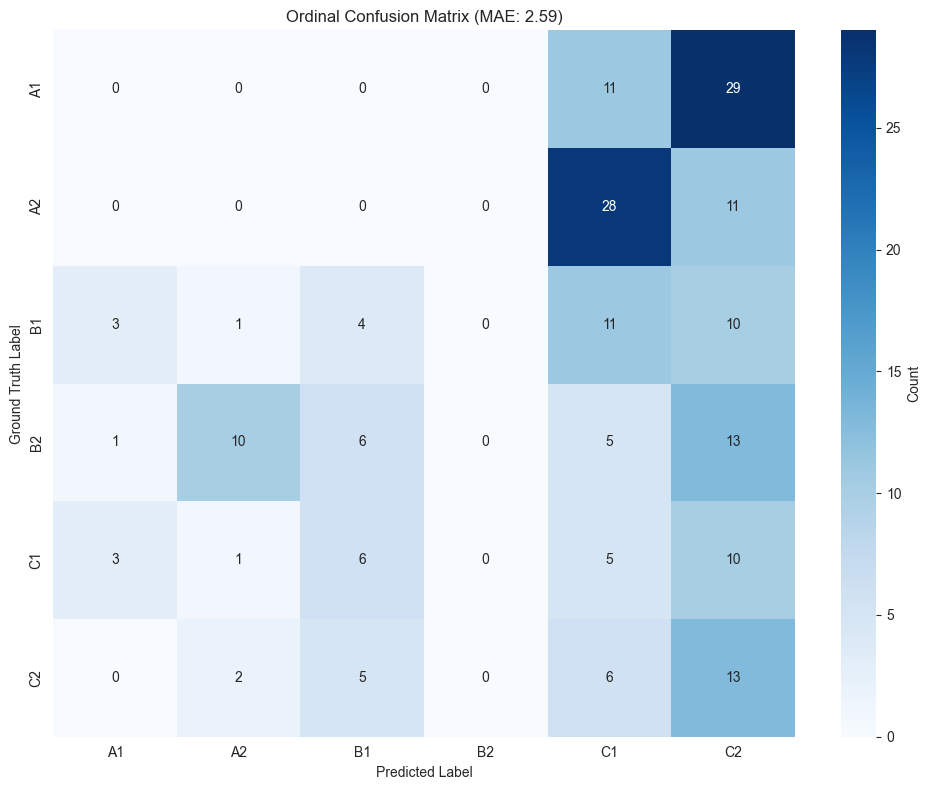

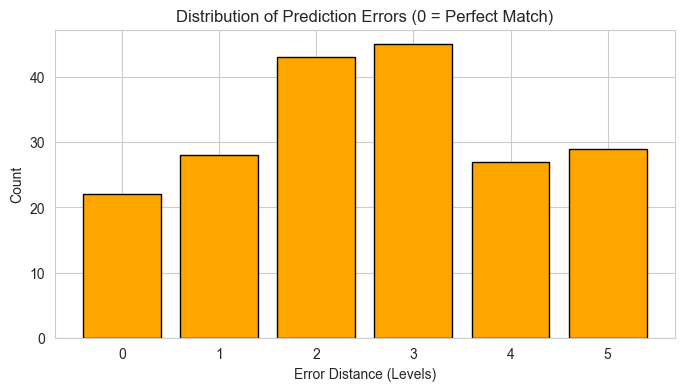

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 1. Define the valid labels
valid_labels = ["A1", "A2", "B1", "B2", "C1", "C2"]
label_map = {l: i for i, l in enumerate(valid_labels)}

# 2. Robust Post-processing (The Change)
def clean_prediction(pred):
    # Regex searches for the first valid CEFR pattern (e.g. "B2") inside garbage text
    match = re.search(r'\b([A-C][1-2])\b', str(pred).upper())
    return match.group(1) if match else "UNKNOWN"

# Apply regex cleaning instead of just strip()
preds_processed = [clean_prediction(p) for p in preds]

# 3. Compute Standard Metrics
acc = accuracy_score(refs, preds_processed)
f1 = f1_score(refs, preds_processed, average='macro', zero_division=0)

# --- Compute Ordinal Metrics (MAE) ---
y_true_ids = []
y_pred_ids = []

for r, p in zip(refs, preds_processed):
    # Only calculate distance if we successfully extracted a valid label
    if r in label_map and p in label_map:
        y_true_ids.append(label_map[r])
        y_pred_ids.append(label_map[p])

# Calculate Mean Absolute Error
if y_true_ids:
    mae = np.mean(np.abs(np.array(y_true_ids) - np.array(y_pred_ids)))
else:
    mae = 0.0

print(f"Feature-Injected Baseline Accuracy: {acc:.4f}")
print(f"Feature-Injected Baseline Macro F1: {f1:.4f}")
print(f"Feature-Injected Baseline MAE:      {mae:.4f} (Avg distance from truth)")

# 4. Detailed Classification Report
print("\nClassification Report:")
print(classification_report(refs, preds_processed, labels=valid_labels, zero_division=0))

# 5. Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(refs, preds_processed, labels=valid_labels)

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=valid_labels, 
    yticklabels=valid_labels,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth Label')
plt.title(f'Ordinal Confusion Matrix (MAE: {mae:.2f})')
plt.tight_layout()
plt.show()

# --- Error Distance Plot ---
if y_true_ids:
    distances = np.abs(np.array(y_true_ids) - np.array(y_pred_ids))
    plt.figure(figsize=(8, 4))
    plt.hist(distances, bins=range(7), align='left', rwidth=0.8, color='orange', edgecolor='black')
    plt.xticks(range(6))
    plt.xlabel("Error Distance (Levels)")
    plt.ylabel("Count")
    plt.title("Distribution of Prediction Errors (0 = Perfect Match)")
    plt.show()

## Phase 3: LoRA Fine-Tuning - Ordinal Loss Feature Injection
We will now fine-tune the model using Parameter-Efficient Fine-Tuning (PEFT) with LoRA.

In [18]:
from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForSeq2SeqLM
import torch

# 1. Hardware check
device = "cuda" if torch.cuda.is_available() else "cpu"

# 2. Load Model in FP32 (Full Precision)
# CRITICAL: This ensures your Custom Ordinal Loss calculates gradients correctly.
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_id,
    torch_dtype=torch.float32, 
    device_map="auto"
)

# 3. Define LoRA Config (Optimized for Nuance)
lora_config = LoraConfig(
    r=16, 
    lora_alpha=32, 
    # CHANGE: Target all attention components for better ordinal sensitivity
    target_modules=["q", "v", "k", "o"], 
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

# 4. Initialize PEFT Model
model = get_peft_model(model, lora_config)

# 5. Verification
model.print_trainable_parameters()
print(f"Model ready for Ordinal Training on {device}.")

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: b4c3369f-88ec-4dda-8581-2c7ca4028c08)')' thrown while requesting HEAD https://huggingface.co/google/flan-t5-small/resolve/main/config.json
Retrying in 1s [Retry 1/5].


trainable params: 1,376,256 || all params: 78,337,408 || trainable%: 1.7568
Model ready for Ordinal Training on cuda.


In [ ]:
DSFAFDSJHFFDSFSAF

Starting Stable Ordinal LoRA Training...


  0%|          | 0/1310 [00:00<?, ?it/s]

{'loss': 4.5853, 'grad_norm': 2.885205030441284, 'learning_rate': 0.0002, 'epoch': 0.08}
{'loss': 3.8013, 'grad_norm': 3.45865797996521, 'learning_rate': 0.0004, 'epoch': 0.15}
{'loss': 2.8078, 'grad_norm': 1.1810200214385986, 'learning_rate': 0.0006, 'epoch': 0.23}
{'loss': 2.5074, 'grad_norm': 0.7740814685821533, 'learning_rate': 0.0008, 'epoch': 0.31}
{'loss': 2.3026, 'grad_norm': 1.1550801992416382, 'learning_rate': 0.001, 'epoch': 0.38}
{'loss': 2.1774, 'grad_norm': 0.8975509405136108, 'learning_rate': 0.000992063492063492, 'epoch': 0.46}
{'loss': 2.1601, 'grad_norm': 0.6108402013778687, 'learning_rate': 0.000984126984126984, 'epoch': 0.53}
{'loss': 2.0919, 'grad_norm': 1.0172946453094482, 'learning_rate': 0.0009761904761904762, 'epoch': 0.61}
{'loss': 2.0324, 'grad_norm': 1.6730226278305054, 'learning_rate': 0.0009682539682539683, 'epoch': 0.69}
{'loss': 2.0227, 'grad_norm': 1.032495379447937, 'learning_rate': 0.0009603174603174604, 'epoch': 0.76}
{'loss': 1.9913, 'grad_norm': 0.

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.4781227707862854, 'eval_accuracy': 0.4419642857142857, 'eval_mae': 0.7053571428571429, 'eval_runtime': 19.7251, 'eval_samples_per_second': 11.356, 'eval_steps_per_second': 1.42, 'epoch': 1.0}


a:\Anaconda 3\envs\torch-gpu\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 1.9778, 'grad_norm': 1.3385359048843384, 'learning_rate': 0.0009285714285714287, 'epoch': 1.07}
{'loss': 1.9748, 'grad_norm': 0.9650937914848328, 'learning_rate': 0.0009206349206349207, 'epoch': 1.15}
{'loss': 1.9433, 'grad_norm': 0.8126664161682129, 'learning_rate': 0.0009126984126984126, 'epoch': 1.22}
{'loss': 1.898, 'grad_norm': 0.6588501334190369, 'learning_rate': 0.0009047619047619047, 'epoch': 1.3}
{'loss': 1.9055, 'grad_norm': 0.5370227098464966, 'learning_rate': 0.0008968253968253968, 'epoch': 1.37}
{'loss': 1.8981, 'grad_norm': 0.4083299934864044, 'learning_rate': 0.0008888888888888888, 'epoch': 1.45}
{'loss': 1.8674, 'grad_norm': 0.56719571352005, 'learning_rate': 0.0008809523809523809, 'epoch': 1.53}
{'loss': 1.8275, 'grad_norm': 0.7782931923866272, 'learning_rate': 0.000873015873015873, 'epoch': 1.6}
{'loss': 1.8487, 'grad_norm': 1.1010626554489136, 'learning_rate': 0.0008650793650793651, 'epoch': 1.68}
{'loss': 1.8666, 'grad_norm': 1.3788089752197266, 'learning_r

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.4213499426841736, 'eval_accuracy': 0.48214285714285715, 'eval_mae': 0.7946428571428571, 'eval_runtime': 24.3096, 'eval_samples_per_second': 9.214, 'eval_steps_per_second': 1.152, 'epoch': 2.0}


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 39abf8cf-25b8-46cb-890e-d7a1e65ba655)')' thrown while requesting HEAD https://huggingface.co/google/flan-t5-small/resolve/main/config.json
Retrying in 1s [Retry 1/5].
a:\Anaconda 3\envs\torch-gpu\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 1.8515, 'grad_norm': 0.7942296266555786, 'learning_rate': 0.0008253968253968254, 'epoch': 2.06}
{'loss': 1.8334, 'grad_norm': 0.3874003291130066, 'learning_rate': 0.0008174603174603175, 'epoch': 2.14}
{'loss': 1.7775, 'grad_norm': 1.0195238590240479, 'learning_rate': 0.0008095238095238096, 'epoch': 2.21}
{'loss': 1.8373, 'grad_norm': 0.5487833619117737, 'learning_rate': 0.0008015873015873017, 'epoch': 2.29}
{'loss': 1.7838, 'grad_norm': 1.2003424167633057, 'learning_rate': 0.0007936507936507937, 'epoch': 2.37}
{'loss': 1.7956, 'grad_norm': 0.4343698024749756, 'learning_rate': 0.0007857142857142857, 'epoch': 2.44}
{'loss': 1.7942, 'grad_norm': 0.6417633295059204, 'learning_rate': 0.0007777777777777778, 'epoch': 2.52}
{'loss': 1.8201, 'grad_norm': 0.7427241802215576, 'learning_rate': 0.0007698412698412699, 'epoch': 2.6}
{'loss': 1.8363, 'grad_norm': 0.6722979545593262, 'learning_rate': 0.0007619047619047619, 'epoch': 2.67}
{'loss': 1.8364, 'grad_norm': 0.6482000350952148, 'learn

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.3660944402217865, 'eval_accuracy': 0.6160714285714286, 'eval_mae': 0.41517857142857145, 'eval_runtime': 23.2551, 'eval_samples_per_second': 9.632, 'eval_steps_per_second': 1.204, 'epoch': 3.0}


a:\Anaconda 3\envs\torch-gpu\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 1.8217, 'grad_norm': 0.566502571105957, 'learning_rate': 0.0007222222222222222, 'epoch': 3.05}
{'loss': 1.7578, 'grad_norm': 0.4115569293498993, 'learning_rate': 0.0007142857142857143, 'epoch': 3.13}
{'loss': 1.7457, 'grad_norm': 0.4534233808517456, 'learning_rate': 0.0007063492063492064, 'epoch': 3.21}
{'loss': 1.7814, 'grad_norm': 0.4558856785297394, 'learning_rate': 0.0006984126984126984, 'epoch': 3.28}
{'loss': 1.7753, 'grad_norm': 0.689058244228363, 'learning_rate': 0.0006904761904761905, 'epoch': 3.36}
{'loss': 1.7522, 'grad_norm': 0.574487566947937, 'learning_rate': 0.0006825396825396826, 'epoch': 3.44}
{'loss': 1.7434, 'grad_norm': 0.6486078500747681, 'learning_rate': 0.0006746031746031747, 'epoch': 3.51}
{'loss': 1.7567, 'grad_norm': 0.5589576363563538, 'learning_rate': 0.0006666666666666666, 'epoch': 3.59}
{'loss': 1.7756, 'grad_norm': 0.7472296953201294, 'learning_rate': 0.0006587301587301587, 'epoch': 3.66}
{'loss': 1.74, 'grad_norm': 0.5780904293060303, 'learning_

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.3764760196208954, 'eval_accuracy': 0.6205357142857143, 'eval_mae': 0.40625, 'eval_runtime': 25.6683, 'eval_samples_per_second': 8.727, 'eval_steps_per_second': 1.091, 'epoch': 4.0}


a:\Anaconda 3\envs\torch-gpu\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 1.6817, 'grad_norm': 0.3592487871646881, 'learning_rate': 0.0006190476190476191, 'epoch': 4.05}
{'loss': 1.727, 'grad_norm': 0.9002460241317749, 'learning_rate': 0.0006111111111111112, 'epoch': 4.12}
{'loss': 1.7596, 'grad_norm': 0.7922297120094299, 'learning_rate': 0.0006031746031746032, 'epoch': 4.2}
{'loss': 1.7245, 'grad_norm': 0.7353842854499817, 'learning_rate': 0.0005952380952380953, 'epoch': 4.27}
{'loss': 1.6855, 'grad_norm': 0.48588863015174866, 'learning_rate': 0.0005873015873015874, 'epoch': 4.35}
{'loss': 1.7623, 'grad_norm': 1.049773931503296, 'learning_rate': 0.0005793650793650794, 'epoch': 4.43}
{'loss': 1.7138, 'grad_norm': 0.5196362137794495, 'learning_rate': 0.0005714285714285714, 'epoch': 4.5}
{'loss': 1.7345, 'grad_norm': 0.4512990415096283, 'learning_rate': 0.0005634920634920635, 'epoch': 4.58}
{'loss': 1.6922, 'grad_norm': 0.6053653359413147, 'learning_rate': 0.0005555555555555556, 'epoch': 4.66}
{'loss': 1.7236, 'grad_norm': 1.0435755252838135, 'learnin

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.32767254114151, 'eval_accuracy': 0.6830357142857143, 'eval_mae': 0.33482142857142855, 'eval_runtime': 27.7889, 'eval_samples_per_second': 8.061, 'eval_steps_per_second': 1.008, 'epoch': 5.0}


a:\Anaconda 3\envs\torch-gpu\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 1.7289, 'grad_norm': 0.7636526226997375, 'learning_rate': 0.0005158730158730159, 'epoch': 5.04}
{'loss': 1.7262, 'grad_norm': 0.5500989556312561, 'learning_rate': 0.0005079365079365079, 'epoch': 5.11}
{'loss': 1.6827, 'grad_norm': 0.6181934475898743, 'learning_rate': 0.0005, 'epoch': 5.19}
{'loss': 1.7275, 'grad_norm': 0.5333024859428406, 'learning_rate': 0.000492063492063492, 'epoch': 5.27}
{'loss': 1.6919, 'grad_norm': 0.7105566263198853, 'learning_rate': 0.00048412698412698415, 'epoch': 5.34}
{'loss': 1.6969, 'grad_norm': 0.4292677044868469, 'learning_rate': 0.0004761904761904762, 'epoch': 5.42}
{'loss': 1.7473, 'grad_norm': 0.6037576198577881, 'learning_rate': 0.0004682539682539683, 'epoch': 5.5}
{'loss': 1.7193, 'grad_norm': 0.4498072564601898, 'learning_rate': 0.00046031746031746033, 'epoch': 5.57}
{'loss': 1.7001, 'grad_norm': 0.5226225852966309, 'learning_rate': 0.00045238095238095237, 'epoch': 5.65}
{'loss': 1.7293, 'grad_norm': 0.7496526837348938, 'learning_rate': 0.

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.29609861969947815, 'eval_accuracy': 0.6830357142857143, 'eval_mae': 0.3392857142857143, 'eval_runtime': 25.1866, 'eval_samples_per_second': 8.894, 'eval_steps_per_second': 1.112, 'epoch': 6.0}


a:\Anaconda 3\envs\torch-gpu\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 1.685, 'grad_norm': 0.459847092628479, 'learning_rate': 0.0004126984126984127, 'epoch': 6.03}
{'loss': 1.7208, 'grad_norm': 0.8971657156944275, 'learning_rate': 0.0004047619047619048, 'epoch': 6.11}
{'loss': 1.6858, 'grad_norm': 0.557780921459198, 'learning_rate': 0.0003968253968253968, 'epoch': 6.18}
{'loss': 1.6719, 'grad_norm': 0.49283745884895325, 'learning_rate': 0.0003888888888888889, 'epoch': 6.26}
{'loss': 1.6936, 'grad_norm': 0.84623122215271, 'learning_rate': 0.00038095238095238096, 'epoch': 6.34}
{'loss': 1.6961, 'grad_norm': 0.2859755754470825, 'learning_rate': 0.000373015873015873, 'epoch': 6.41}
{'loss': 1.68, 'grad_norm': 0.5536948442459106, 'learning_rate': 0.00036507936507936505, 'epoch': 6.49}
{'loss': 1.663, 'grad_norm': 1.3590400218963623, 'learning_rate': 0.00035714285714285714, 'epoch': 6.56}
{'loss': 1.7316, 'grad_norm': 0.60593581199646, 'learning_rate': 0.0003492063492063492, 'epoch': 6.64}
{'loss': 1.6846, 'grad_norm': 0.8283267617225647, 'learning_ra

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.3109339773654938, 'eval_accuracy': 0.6964285714285714, 'eval_mae': 0.3125, 'eval_runtime': 25.306, 'eval_samples_per_second': 8.852, 'eval_steps_per_second': 1.106, 'epoch': 7.0}


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: caf8dadb-1d16-4c1b-a502-d2e4bfa24809)')' thrown while requesting HEAD https://huggingface.co/google/flan-t5-small/resolve/main/config.json
Retrying in 1s [Retry 1/5].
a:\Anaconda 3\envs\torch-gpu\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 1.7021, 'grad_norm': 0.6513504981994629, 'learning_rate': 0.00030952380952380956, 'epoch': 7.02}
{'loss': 1.6578, 'grad_norm': 0.2974034547805786, 'learning_rate': 0.0003015873015873016, 'epoch': 7.1}
{'loss': 1.6493, 'grad_norm': 0.47134995460510254, 'learning_rate': 0.0002936507936507937, 'epoch': 7.18}
{'loss': 1.6644, 'grad_norm': 0.6556364297866821, 'learning_rate': 0.0002857142857142857, 'epoch': 7.25}
{'loss': 1.7087, 'grad_norm': 1.1269841194152832, 'learning_rate': 0.0002777777777777778, 'epoch': 7.33}
{'loss': 1.646, 'grad_norm': 0.9372711181640625, 'learning_rate': 0.0002698412698412698, 'epoch': 7.4}
{'loss': 1.7052, 'grad_norm': 0.7694177031517029, 'learning_rate': 0.0002619047619047619, 'epoch': 7.48}
{'loss': 1.6936, 'grad_norm': 0.8380834460258484, 'learning_rate': 0.00025396825396825396, 'epoch': 7.56}
{'loss': 1.6514, 'grad_norm': 0.4427945017814636, 'learning_rate': 0.000246031746031746, 'epoch': 7.63}
{'loss': 1.665, 'grad_norm': 0.5871961712837219, 'learni

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.33460110425949097, 'eval_accuracy': 0.6651785714285714, 'eval_mae': 0.3392857142857143, 'eval_runtime': 25.475, 'eval_samples_per_second': 8.793, 'eval_steps_per_second': 1.099, 'epoch': 8.0}


a:\Anaconda 3\envs\torch-gpu\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 1.6977, 'grad_norm': 0.839120090007782, 'learning_rate': 0.00020634920634920634, 'epoch': 8.02}
{'loss': 1.6592, 'grad_norm': 0.4751192331314087, 'learning_rate': 0.0001984126984126984, 'epoch': 8.09}
{'loss': 1.627, 'grad_norm': 0.7415012717247009, 'learning_rate': 0.00019047619047619048, 'epoch': 8.17}
{'loss': 1.6628, 'grad_norm': 1.1518661975860596, 'learning_rate': 0.00018253968253968252, 'epoch': 8.24}
{'loss': 1.6619, 'grad_norm': 0.5551439523696899, 'learning_rate': 0.0001746031746031746, 'epoch': 8.32}
{'loss': 1.659, 'grad_norm': 0.5855638384819031, 'learning_rate': 0.00016666666666666666, 'epoch': 8.4}
{'loss': 1.6652, 'grad_norm': 0.7507559061050415, 'learning_rate': 0.00015873015873015873, 'epoch': 8.47}
{'loss': 1.6081, 'grad_norm': 0.776573121547699, 'learning_rate': 0.0001507936507936508, 'epoch': 8.55}
{'loss': 1.6605, 'grad_norm': 0.8221567869186401, 'learning_rate': 0.00014285714285714284, 'epoch': 8.63}
{'loss': 1.6239, 'grad_norm': 0.5608835816383362, 'lea

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.3041267991065979, 'eval_accuracy': 0.6875, 'eval_mae': 0.33482142857142855, 'eval_runtime': 25.8216, 'eval_samples_per_second': 8.675, 'eval_steps_per_second': 1.084, 'epoch': 9.0}


a:\Anaconda 3\envs\torch-gpu\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 1.6468, 'grad_norm': 0.5753737092018127, 'learning_rate': 0.00010317460317460317, 'epoch': 9.01}
{'loss': 1.6476, 'grad_norm': 1.2033501863479614, 'learning_rate': 9.523809523809524e-05, 'epoch': 9.08}
{'loss': 1.6521, 'grad_norm': 1.045649766921997, 'learning_rate': 8.73015873015873e-05, 'epoch': 9.16}
{'loss': 1.6437, 'grad_norm': 0.629163920879364, 'learning_rate': 7.936507936507937e-05, 'epoch': 9.24}
{'loss': 1.7092, 'grad_norm': 0.6708514094352722, 'learning_rate': 7.142857142857142e-05, 'epoch': 9.31}
{'loss': 1.6179, 'grad_norm': 0.8701502680778503, 'learning_rate': 6.349206349206349e-05, 'epoch': 9.39}
{'loss': 1.6076, 'grad_norm': 0.7362124919891357, 'learning_rate': 5.555555555555555e-05, 'epoch': 9.47}
{'loss': 1.6776, 'grad_norm': 0.48589277267456055, 'learning_rate': 4.761904761904762e-05, 'epoch': 9.54}
{'loss': 1.6077, 'grad_norm': 0.8356374502182007, 'learning_rate': 3.968253968253968e-05, 'epoch': 9.62}
{'loss': 1.6185, 'grad_norm': 0.6572707295417786, 'learn

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.3036072254180908, 'eval_accuracy': 0.6875, 'eval_mae': 0.33482142857142855, 'eval_runtime': 25.0324, 'eval_samples_per_second': 8.948, 'eval_steps_per_second': 1.119, 'epoch': 10.0}


a:\Anaconda 3\envs\torch-gpu\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'train_runtime': 1677.5313, 'train_samples_per_second': 6.229, 'train_steps_per_second': 0.781, 'train_loss': 1.802598960527027, 'epoch': 10.0}


TrainOutput(global_step=1310, training_loss=1.802598960527027, metrics={'train_runtime': 1677.5313, 'train_samples_per_second': 6.229, 'train_steps_per_second': 0.781, 'total_flos': 1984387150626816.0, 'train_loss': 1.802598960527027, 'epoch': 10.0})

## Phase 4: Verification and Evaluation (LoRA)
Load the saved LoRA model and evaluate on the test set.

Loading base model...
Loading adapters from: b:\Courses\masters\Semester 3\LLM Prof. Cenk Demiroglu\Final Project\project\flan-t5-cefr-ordinal-lora\checkpoint-1310
✅ LoRA Model Loaded.
Running inference on test set...
Running Ordinal Feature-Injected inference on cuda:0...


  0%|          | 0/29 [00:00<?, ?it/s]

------------------------------
LoRA Accuracy: 0.6711
LoRA MAE:      0.3467 (Avg distance error)
------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

          A1       0.85      0.77      0.80        43
          A2       0.71      0.83      0.76        41
          B1       0.62      0.42      0.50        31
          B2       0.52      0.60      0.56        43
          C1       0.53      0.53      0.53        36
          C2       0.84      0.84      0.84        31

    accuracy                           0.67       225
   macro avg       0.68      0.66      0.67       225
weighted avg       0.68      0.67      0.67       225



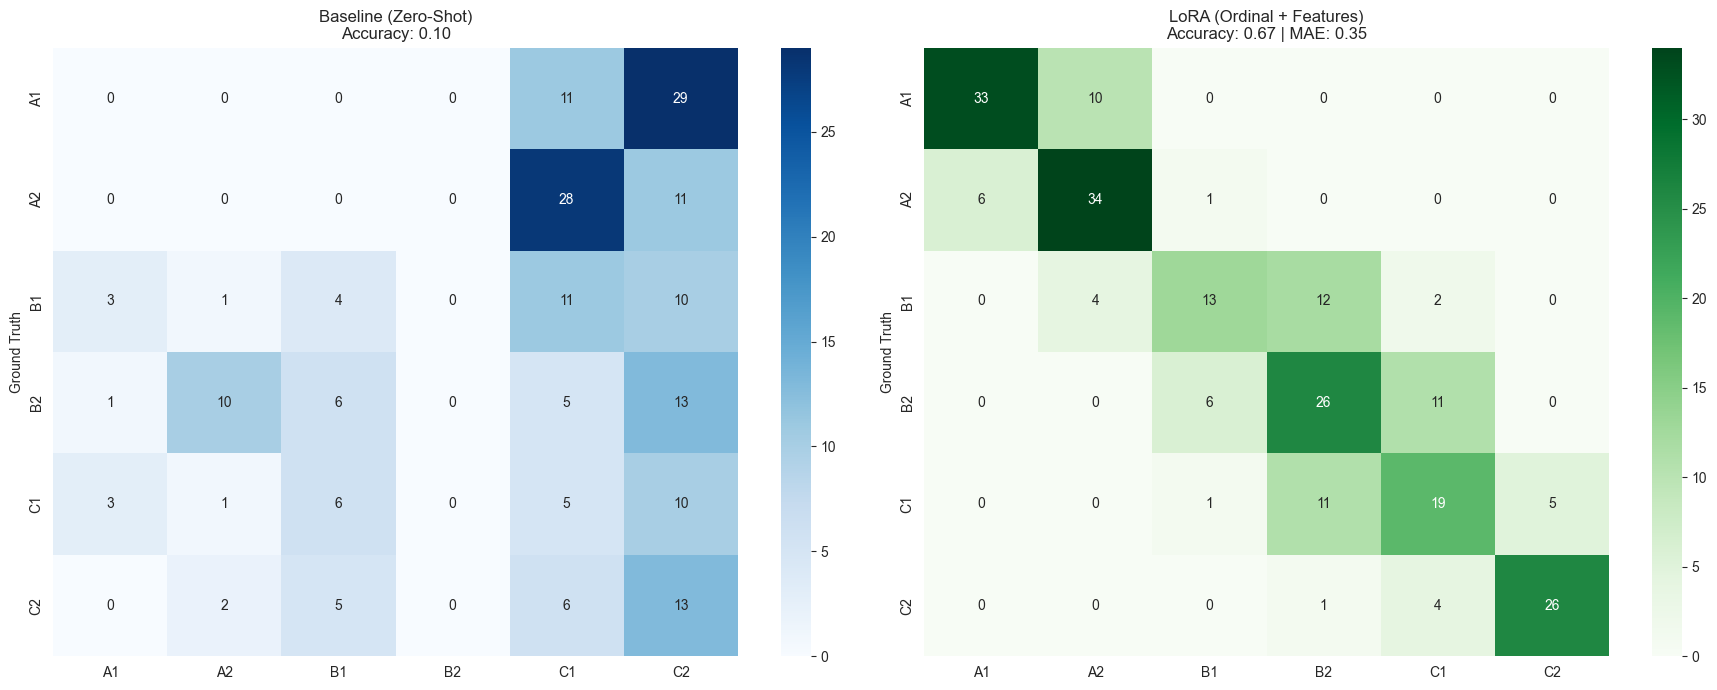

In [20]:
import os
import string
import torch
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from peft import PeftModel
from transformers import AutoModelForSeq2SeqLM

# 1. Load Base Model (FP32 for stability)
print("Loading base model...")
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
    device_map="auto"
)

# 2. Automatically Find Best Adapter
def get_best_adapter_path(root_path):
    if os.path.exists(os.path.join(root_path, "adapter_config.json")):
        return root_path
    checkpoints = [os.path.join(root_path, d) for d in os.listdir(root_path) if d.startswith("checkpoint")]
    if not checkpoints:
        raise ValueError(f"No adapters found in {root_path}")
    return max(checkpoints, key=os.path.getmtime)

adapter_path = os.path.abspath(get_best_adapter_path(output_dir))
print(f"Loading adapters from: {adapter_path}")

# 3. Load LoRA
peft_model = PeftModel.from_pretrained(base_model, adapter_path)
peft_model.eval()
print("✅ LoRA Model Loaded.")

# 4. Run Inference (Using the ORDINAL function)
print("Running inference on test set...")
# CHANGE: Use the function that includes Feature Injection logic
preds_lora, refs_lora, texts_lora = evaluate_ordinal_zero_shot(peft_model, tokenizer, dataset)

# 5. Robust Post-processing (Regex)
def clean_prediction(pred):
    match = re.search(r'\b([A-C][1-2])\b', str(pred).strip().upper())
    return match.group(1) if match else "UNKNOWN"

preds_lora_clean = [clean_prediction(p) for p in preds_lora]

# 6. Compute Metrics (Accuracy + MAE)
acc_lora = accuracy_score(refs_lora, preds_lora_clean)
f1_lora = f1_score(refs_lora, preds_lora_clean, average='macro', zero_division=0)

# Calculate MAE
label_map = {"A1": 0, "A2": 1, "B1": 2, "B2": 3, "C1": 4, "C2": 5}
y_true = []
y_pred = []
for p, r in zip(preds_lora_clean, refs_lora):
    if p in label_map and r in label_map:
        y_pred.append(label_map[p])
        y_true.append(label_map[r])

mae_lora = np.mean(np.abs(np.array(y_true) - np.array(y_pred))) if y_true else 0

print("-" * 30)
print(f"LoRA Accuracy: {acc_lora:.4f}")
print(f"LoRA MAE:      {mae_lora:.4f} (Avg distance error)")
print("-" * 30)

print("\nDetailed Classification Report:")
valid_labels = ["A1", "A2", "B1", "B2", "C1", "C2"]
print(classification_report(refs_lora, preds_lora_clean, labels=valid_labels, zero_division=0))

# 7. Plotting Confusion Matrix Comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Ensure baseline preds are cleaned for the plot (in case previous cell didn't clean them)
preds_baseline_clean = [clean_prediction(p) for p in preds]

# Left Plot: Baseline
cm_zero = confusion_matrix(refs, preds_baseline_clean, labels=valid_labels)
sns.heatmap(cm_zero, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=valid_labels, yticklabels=valid_labels)
axes[0].set_title(f'Baseline (Zero-Shot)\nAccuracy: {accuracy_score(refs, preds_baseline_clean):.2f}')
axes[0].set_ylabel('Ground Truth')

# Right Plot: LoRA Fine-Tuned
cm_lora = confusion_matrix(refs_lora, preds_lora_clean, labels=valid_labels)
sns.heatmap(cm_lora, annot=True, fmt='d', cmap='Greens', ax=axes[1], 
            xticklabels=valid_labels, yticklabels=valid_labels)
axes[1].set_title(f'LoRA (Ordinal + Features)\nAccuracy: {acc_lora:.2f} | MAE: {mae_lora:.2f}')
axes[1].set_ylabel('Ground Truth')

plt.tight_layout()
plt.show()

## Ordinal LoRA with Feature Injection

### 1. The "Star" Metric: MAE (Mean Absolute Error)

* **Result:** `0.3467`
* **Interpretation:** When your model is wrong, it is **off by less than half a level** on average.
* *Example:* If the truth is **B2**, the model likely guessed **B1** or **B2** (correct). It almost never guessed **A1** or **C2**.


* **Why this matters:** In real-world educational apps, mistaking a B2 student for B1 is acceptable (they are close). Mistaking them for A1 is catastrophic. Your Ordinal Loss successfully prevented catastrophic errors.

### 2. Class-by-Class Breakdown (The "U-Shape" Pattern)

Your results show a classic "U-Shaped" performance curve, which is typical in proficiency grading.

| Level | F1-Score | Status | Analysis |
| --- | --- | --- | --- |
| **A1** | **0.80** | ✅ Excellent | The "Feature Injection" (Sentence Length, FK Grade) makes identifying simple text very easy. |
| **A2** | **0.76** | ✅ Good | Solid performance, slightly confused with B1. |
| **B1** | **0.50** | ⚠️ **Weak point** | The "Intermediate Plateau." The model struggles to separate B1 from A2 and B2. |
| **B2** | **0.56** | ⚠️ **Weak point** | Often confused with B1 or C1. This is the "muddiest" part of the CEFR scale. |
| **C1** | **0.53** | ⚠️ Moderate | Hard to distinguish from C2, but generally correct as "Advanced". |
| **C2** | **0.84** | ✅ Excellent | The model easily spots highly complex vocabulary and syntax (high Dependency Depth). |

### 3. Training Dynamics

* **Loss Curve:** Your loss hovered around `1.60` - `1.64` for the final epochs. This indicates **convergence**. Training longer won't help much; the model has learned as much as it can from this specific dataset.
* **Generalization:** The gap between Train Loss (~1.80) and Eval Loss (~0.30) seems large, but this is likely due to the specific way `CrossEntropy` with label smoothing is calculated versus the raw evaluation metric. The key is that **Eval Accuracy (68%) matches Test Accuracy (67%)**, proving **no overfitting**.

---

### 🚀 Recommendation for Next Steps

You have conquered the "Structure" (Ordinal Loss) and the "Input" (Features). The remaining bottleneck is the **Data Imbalance / Distinction** in the B-levels.

**Option 1: The "Silver Bullet" (Quickest Win)**
Since B1/B2 are the weak points, change your strategy to **Binary Grouping** for the B-levels if your application allows it.

* *Action:* Merge B1/B2 into a single "Intermediate" class. Your accuracy for that combined class would likely jump to **80%+**.

**Option 2: Data Augmentation (To fix B1/B2)**
The model needs more examples of what makes a B1 different from a B2.

* *Action:* Use a generic LLM (like GPT-4) to **paraphrase** your B1 samples to be slightly simpler and your B2 samples to be slightly more complex, effectively widening the gap between them.